# Les économistes de DBPedia – Introduction


Cet ensemble de carnets a pour finalité d'analyser les principales propriétés des personnes identifiées comme économistes dans DBPedia en anglais. Cf. par exemple les données relatives à [John Maynard Keynes](https://dbpedia.org/page/John_Maynard_Keynes).

La finalité de l'analyse est non seulement de cerner le profil de cette population à partir des propriétés disponibles dans DBPedia mais surtout d'illustrer le potentiel de différentes techniques d'exploration et d'analyse de données. 

La source des données est représentée par DBPedia et donc, par son intermédiaire, par Wikipedia qui est la source principale de ces données extraites automatiquement des '[Infobox](https://en.wikipedia.org/wiki/Infobox)' et textes de l'encyclopédie collaborative. Les données sont récupérées grâce aux requêtes SPARQL exécutées sur le point d'accès SPARQL de DBPedia : https://dbpedia.org/sparql.


Dans le carnet [dbpedia_exploration.ipynb](dbpedia_exploration.ipynb) on procède à l'analyse des manières d'identifier la population des économistes, puis à l'exploration des propriétés disponibles qui les concernent. Les requêtes sont stockées dans une base de données SQLite afin de pouvoir les gérer facilement et ajouter des annotations et commentaires. 


Les requêtes 19 et 8 de la base de données permettent d'identifier 6868 personnes en tant qu'économistes (résultat au 7 mai 2021) et de lister et compter leurs propriétés. Parmi celles-ci les plus fréquentes ou les plus significatives, comme nationalité, ou Université fréquentée, etc. ont été retenues et stockées dans une table dédiée de la base de données SQLite afin de pouvoir être nettoyées et analysées. Le processus de production est documenté dans le carnet [dbpedia_production.ipynb](dbpedia_production.ipynb).

Ci-dessous on trouvera une exploration des propriétés qui ont été retenues et des considérations concernant leur analyse qui renvoient également aux autres carnets réalisés.


### Librairies

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

In [2]:
import pprint
import csv
import ast
import re

from collections import Counter
from operator import itemgetter

import sqlite3 as sql
import time
import statistics as stat

from importlib import reload
from shutil import copyfile

## Base de données

In [3]:
### Définir les adresses des fichiers, l'existant et celui à créer
db = 'data/sparql_queries.db'

In [4]:
### Fonction qui récupère et met en forme le temps au moment de l'exécution

# définition
def timestamp_formatted_for_file_name():
    is_now = time.strftime('%Y%m%d_%H%M%S')
    return is_now

# exécution
timestamp_formatted_for_file_name()

'20210602_234222'

In [6]:
##  Préparation du nom de la copie
timestamped_db_copy = 'data/sparql_queries_' + timestamp_formatted_for_file_name() + '.sqlite'

In [7]:
### Créer une copie de sauvegarde avec timestamp du fichier (versionnement manuel)
## Cette requête n'est utile que si des modifications en écriture vont être apportées à la base de données,
# afint de préserver le dernier état avant modification

## Documentation:
# https://docs.python.org/3/library/shutil.htmlcopied_db = copyfile(original_db, timestamped_db_copy)

copied_db = copyfile(db, timestamped_db_copy)
copied_db

'data/sparql_queries_20210531_235058.sqlite'

## Préparation des propriétés des personnes qui ont été extraites de DBPedia

Étant donné que la dimension diachronique est essentielle dans les sciences historiques, l'analyse sera restreinte aux personnes qui disposent d'une année de naissance, afin de pouvoir les situer sur l'échelle du temps.

Le nettoyage et la production d'une propriété 'année de naissance' sont documentés dans ce carnet [dbpedia_production.ipynb](dbpedia_production.ipynb), en bas: "Ajout des années de naissance nettoyées".

Sont retenues ici les principales propriétés stockées dans la base de données pour les personnes nées en 1771 et après, actives donc à partir de la Révolution française et des guerres qui se sont suivies et ont changé la carte de l'Europe, en marquant la transition vers l'époque contemporaine.

* Nombre de personnes dans la base de données : 6868 

<code> WITH tw1 AS (SELECT DISTINCT uri_entity 
FROM entity
WHERE entity_class = 'https://dbpedia.org/ontology/Person')
SELECT count(*) FROM tw1;
</code>

* Nombre de personnes avec une années de naissance : 3849

<code>SELECT COUNT(*)
FROM (
SELECT DISTINCT uri_entity
FROM property
WHERE property LIKE '%ontology/birthYear' );
</code>




In [5]:
### Requête qui regroupe toutes les propriétés qu'on souhaite analyser et comparer
#  Ajouter des sous-requêtes pour chacune des propriétés, regrouper dans le GROUP BY final
##  La clause LEFT JOIN permet d'obtenir les résultats disponibles pour chaque propriété et personne, 
# tout en laissant des lignes vides pour les personnes qui n'ont pas telle ou telle propriété
# Restriction sur la période, nées en 1771 et après

personnes_proprietes = """
WITH tw1 AS(
SELECT DISTINCT uri_entity ,
CASE WHEN value like 'http%'
then replace(value, 'http://dbpedia.org/resource/', '')
else value END field
FROM property
WHERE property IN ('http://dbpedia.org/property/field', 'http://dbpedia.org/ontology/field')
),
tw2 AS(
SELECT DISTINCT uri_entity ,
CASE WHEN value like 'http%'
then replace(value, 'http://dbpedia.org/resource/', '')
else value END nationality
FROM property
WHERE property IN ('http://dbpedia.org/property/nationality', 'http://dbpedia.org/ontology/nationality')
),
tw3 AS(
SELECT DISTINCT uri_entity ,
CASE WHEN value like 'http%'
then replace(value, 'http://dbpedia.org/resource/', '')
else value END birth_place
FROM property
WHERE property IN ('http://dbpedia.org/ontology/birthPlace')
),
tw4 AS(
SELECT DISTINCT uri_entity ,
CASE WHEN value like 'http%'
then replace(value, 'http://dbpedia.org/resource/', '')
else value END alma_mater
FROM property
WHERE property IN ('http://dbpedia.org/ontology/almaMater')
),
tw5 AS(
-- attention : propriété inversée ! La personne est l'influencé
SELECT DISTINCT  value,
CASE WHEN value like 'http%'
then replace(uri_entity, 'http://dbpedia.org/resource/', '')
else value END influenced_by
FROM property
WHERE property IN ('http://dbpedia.org/ontology/influenced')
),
tw6 AS(
SELECT DISTINCT uri_entity ,
CASE WHEN value like 'http%'
then replace(value, 'http://dbpedia.org/resource/', '')
else value END institution
FROM property
WHERE property IN ('http://dbpedia.org/ontology/institution')
),
tw7 AS(
SELECT DISTINCT uri_entity ,
CASE WHEN value like 'http%'
then replace(value, 'http://dbpedia.org/resource/', '')
else value END occupation
FROM property
WHERE property IN ('http://dbpedia.org/property/occupation', 'http://dbpedia.org/ontology/occupation')
)
SELECT p.uri_entity, 
        -- en cas d'années de naissance multiples la moyenne arrontie à l'entier est retenue
        CAST(ROUND(SUM(p.value)/COUNT(*)) AS INT) annee, 
        GROUP_CONCAT(DISTINCT(tw1.field)) field, 
        GROUP_CONCAT(DISTINCT(tw2.nationality)) nationality,
        GROUP_CONCAT(DISTINCT(tw3.birth_place)) birth_place,
        GROUP_CONCAT(DISTINCT(tw4.alma_mater)) alma_mater,
        GROUP_CONCAT(DISTINCT(tw5.influenced_by)) influenced_by,
        GROUP_CONCAT(DISTINCT(tw6.institution)) institution,
        GROUP_CONCAT(DISTINCT(tw7.occupation)) occupation
FROM property p 
    LEFT JOIN tw1 ON tw1.uri_entity = p.uri_entity
    LEFT JOIN tw2 ON tw2.uri_entity = p.uri_entity
    LEFT JOIN tw3 ON tw3.uri_entity = p.uri_entity
    LEFT JOIN tw4 ON tw4.uri_entity = p.uri_entity
    LEFT JOIN tw5 ON tw5.value = p.uri_entity
    LEFT JOIN tw6 ON tw6.uri_entity = p.uri_entity
    LEFT JOIN tw7 ON tw7.uri_entity = p.uri_entity    
WHERE p.property LIKE '%ontology/birthYear'
GROUP BY p.uri_entity
HAVING annee > 1770
ORDER BY annee;
"""

In [6]:
### Adresse de la base de données
db = 'data/sparql_queries.db'

In [7]:
### Produire un DataFrame à partir de la requête SQL ci-dessus

cn = sql.connect(db)
personnes = pd.read_sql_query(personnes_proprietes, cn)
cn.close()

## Effectif des personnes = nombre de lignes dans le DataFrame
print(len(personnes))

##  Inspecter le DataFrame, deux méthodes: iloc (un certain nombre de lignes indiqué par l'index) ou head() 
personnes.iloc[310:315,]
# personnes.head(40)

3779


,uri_entity,annee,field,nationality,birth_place,alma_mater,influenced_by,institution,occupation
310,http://dbpedia.org/resource/Arrigo_Serpieri,1877,None,Italy,Bologna,None,None,None,"Arrigo_Serpieri__PersonFunction__1,Lecturer"
311,http://dbpedia.org/resource/Arthur_Cecil_Pigou,1877,Welfare_economics,Britain,"Isle_of_Wight,Ryde","King's_College,_Cambridge","Alfred_Marshall,Henry_Sidgwick",University_of_Cambridge,None
312,http://dbpedia.org/resource/D._H._MacGregor,1877,None,"Scotland,Scottish",Monifieth,None,None,None,"D._H._MacGregor__PersonFunction__1,economist"
313,http://dbpedia.org/resource/Farkas_Heller,1877,"Economist,Statistician",Hungarians,"Budapest,Kingdom_of_Hungary",Budapest_University_of_Technology_and_Economics,None,Budapest_University_of_Technology_and_Economics,None
314,http://dbpedia.org/resource/Hjalmar_Schacht,1877,None,German,"German_Empire,Province_of_Schleswig-Holstein,T...",None,None,None,None


In [8]:
## Colonnes dans le tableau
list(personnes.columns)

['uri_entity',
 'annee',
 'field',
 'nationality',
 'birth_place',
 'alma_mater',
 'influenced_by',
 'institution',
 'occupation']

In [9]:
## Mettre 'uri_entity' comme index, créer un nom lisible

personnes['uri_entity'] = personnes['uri_entity'].apply(lambda x : x.replace('http://dbpedia.org/resource/', ''))
personnes['name'] = personnes['uri_entity'].apply(lambda x : x.replace('_', ' '))
personnes.set_index('uri_entity', inplace=True, verify_integrity=True)
personnes.head()

,annee,field,nationality,birth_place,alma_mater,influenced_by,institution,occupation,name
uri_entity,,,,,,,,,
Philipp_Emanuel_von_Fellenberg,1771,None,None,"Bern,Switzerland",University_of_Tübingen,None,None,"Agronomist,Educationalist,Educationalist and a...",Philipp Emanuel von Fellenberg
Charles_Fourier,1772,None,None,Besançon,None,"Nicolas-Edme_Rétif,Victor_Prosper_Considerant",None,None,Charles Fourier
David_Ricardo,1772,None,British,None,None,None,None,None,David Ricardo
Jacob_Aall,1773,None,Norway,Porsgrunn,None,None,None,"Economist,Historian,Landowner,Politician,state...",Jacob Aall
James_Mill,1773,None,None,"Angus,_Scotland",None,"David_Hartley_(philosopher),Dugald_Stewart,Jer...",None,None,James Mill


In [10]:
###  Les colonnes des valeurs contiennent des listes (car une personne peut avoir plusieurs métiers) :
##  compter les effectifs de chaque cellule contenant des propriétés

personnes['len_field'] = personnes['field'].apply(lambda x : len(x.split(',')) if x else 0)
personnes['len_nationality'] = personnes['nationality'].apply(lambda x : len(x.split(',')) if x else 0)
personnes['len_birth_place'] = personnes['birth_place'].apply(lambda x : len(x.split(',')) if x else 0)
personnes['len_alma_mater'] = personnes['alma_mater'].apply(lambda x : len(x.split(',')) if x else 0)
personnes['len_influenced_by'] = personnes['influenced_by'].apply(lambda x : len(x.split(',')) if x else 0)
personnes['len_institution'] = personnes['institution'].apply(lambda x : len(x.split(',')) if x else 0)
personnes['len_occupation'] = personnes['occupation'].apply(lambda x : len(x.split(',')) if x else 0)

In [11]:
### Changer l'ordre des colonnes dans le tableau Pandas pour les mettre dans un ordre suivant le cursus de la personne

personnes = personnes[['name', 'annee', 'nationality', 'len_nationality','birth_place','len_birth_place', \
                       'alma_mater', 'len_alma_mater', 'influenced_by', 'len_influenced_by', 'field', 'len_field',\
                       'occupation', 'len_occupation', 'institution', 'len_institution']]
personnes.iloc[140:145]

,name,annee,nationality,len_nationality,birth_place,len_birth_place,alma_mater,len_alma_mater,influenced_by,len_influenced_by,field,len_field,occupation,len_occupation,institution,len_institution
uri_entity,,,,,,,,,,,,,,,,
Giuseppe_Toniolo,Giuseppe Toniolo,1845,None,0,"Kingdom_of_Lombardy-Venetia,Treviso",2,None,0,None,0,None,0,None,0,None,0
Theodor_Hertzka,Theodor Hertzka,1845,"Austrians,Hungarian_people,Hungarians",3,"Budapest,Kingdom_of_Hungary",2,None,0,None,0,"Monetary_economics,Monetary_theory",2,None,0,None,0
Pieter_Cort_van_der_Linden,Pieter Cort van der Linden,1846,Netherlands,1,"Netherlands,The_Hague",2,"Bachelor_of_Laws,Doctor_of_Philosophy,Leiden_U...",4,None,0,None,0,"Academic_administration,Author,Civil_service,E...",11,None,0
Charles_Gide,Charles Gide,1847,French,1,Uzès,1,None,0,None,0,"History_of_economic_thought,Social_economy,The...",3,None,0,None,0
Ebbe_Hertzberg,Ebbe Hertzberg,1847,Norwegian,1,Holmestrand,1,None,0,None,0,None,0,"Ebbe_Hertzberg__PersonFunction__1,Legal_histor...",3,None,0


### Propriétés par personne

In [12]:
proprietes_personnes = []
for i,r in list(personnes.iterrows()):
    properties = []    
    if r['len_birth_place'] > 0:
        properties.append('birth_place')
    if r['len_nationality'] > 0:        
        properties.append('nationality')
    if r['len_alma_mater'] > 0:
        properties.append('alma_mater')
    if r['len_influenced_by'] > 0:
        properties.append('influenced_by')
    if r['len_field'] > 0:
        properties.append('field')
    if r['len_occupation'] > 0:
        properties.append('occupation')
    if r['len_institution'] > 0:
        properties.append('institution')
            
    proprietes_personnes.append([i, properties, len(properties)])        

    
proprietes_personnes[10:15]

[['William_Thompson_(philosopher)', ['birth_place', 'influenced_by'], 2],
 ['José_María_del_Castillo_y_Rada', ['birth_place'], 1],
 ['Francis_Horner', ['birth_place', 'alma_mater', 'occupation'], 3],
 ['Franciszek_Ksawery_Drucki-Lubecki', [], 0],
 ['Robert_Torrens_(economist)',
  ['birth_place', 'nationality', 'occupation'],
  3]]

In [13]:
df_proprietes_personnes = pd.DataFrame(proprietes_personnes, columns=['uri_personne', 'proprietes', 'effectif'])
df_proprietes_personnes.head()

,uri_personne,proprietes,effectif
0,Philipp_Emanuel_von_Fellenberg,"[birth_place, alma_mater, occupation]",3
1,Charles_Fourier,"[birth_place, influenced_by]",2
2,David_Ricardo,[nationality],1
3,Jacob_Aall,"[birth_place, nationality, occupation]",3
4,James_Mill,"[birth_place, influenced_by]",2


In [14]:
### Compter les effectifs des propriétés par personne
effectifs_proprietes_par_personne = df_proprietes_personnes.groupby('effectif').count()
effectifs_proprietes_par_personne

,uri_personne,proprietes
effectif,,
0,81,81
1,593,593
2,895,895
3,957,957
4,709,709
5,382,382
6,162,162


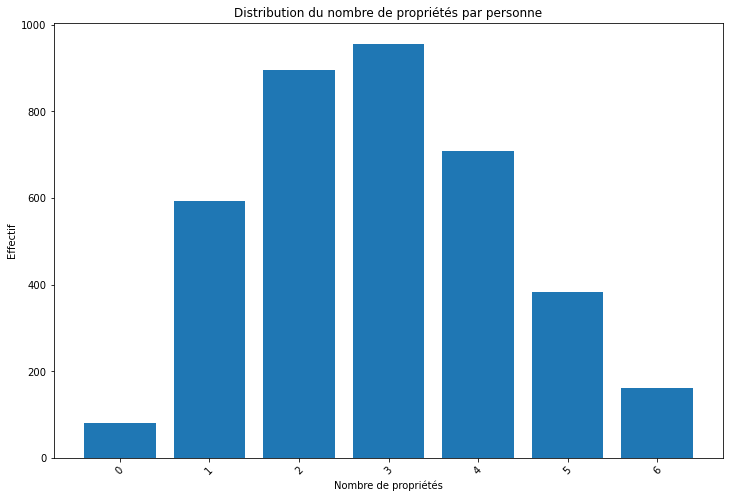

In [15]:
# Distribution de nombre de propriétés par personne

objects = [l for l in effectifs_proprietes_par_personne.index]
eff = [l for l in effectifs_proprietes_par_personne['proprietes']]

p1 = plt.bar(objects, eff)

#plt.xticks(l5Years)
plt.ylabel('Effectif')
plt.xlabel('Nombre de propriétés')
plt.title('Distribution du nombre de propriétés par personne')
plt.gcf().set_size_inches(12, 8)
#plt.gca().axes.get_xaxis().set_visible(False)
# supported formats: eps, pdf, pgf, png, ps, raw, rgba, svg, svgz
#plt.savefig('exported_pictures/effectifs_naissances_par_annee.png', dpi=100, bbox_inches = "tight") #pdf, svg
plt.xticks(rotation=45)
plt.show()


### Combinaisons de propriétés

In [16]:
sr_properties_groups = df_proprietes_personnes['proprietes'].groupby(df_proprietes_personnes['proprietes'].apply(lambda x : ' | '.join(x) )).count().sort_values(ascending=False)
sr_properties_groups.iloc[:30]

proprietes
birth_place                                                                     445
birth_place | alma_mater                                                        368
birth_place | nationality | alma_mater                                          295
birth_place | nationality | alma_mater | occupation                             264
birth_place | nationality | occupation                                          212
birth_place | nationality | alma_mater | field | institution                    198
birth_place | occupation                                                        171
birth_place | nationality | alma_mater | influenced_by | field | institution    162
birth_place | nationality                                                       149
birth_place | alma_mater | occupation                                           122
birth_place | nationality | alma_mater | field                                  105
nationality | alma_mater | field | institution                   

## Distribution des propriétés disponibles

Pour chaque personne de la population on va vérifier si une propriété est renseignée ou non. Une propriété peut être renseignée plusieurs fois pour chaque personne (par ex. on peut avoir fréquenté plusieurs Universités) mais elle sera comptée une seule fois.

Cette méthode permet d'avoir un aperçu des propriétés disponibles et ensuite de décider ce qui pourra être analysé.


In [18]:
eff_personnes = 0
nationality = 0
birth_place = 0
alma_mater = 0
influenced_by = 0
field = 0
occupation = 0
institution = 0
for i,r in list(personnes.iterrows()):
    eff_personnes += 1
    if r['len_nationality'] > 0:        
        nationality += 1
    if r['len_birth_place'] > 0:
        birth_place += 1
    if r['len_alma_mater'] > 0:
        alma_mater += 1
    if r['len_influenced_by'] > 0:
        influenced_by += 1
    if r['len_field'] > 0:
        field += 1
    if r['len_occupation'] > 0:
        occupation += 1
    if r['len_institution'] > 0:
        institution += 1

In [19]:
effectifs_proprietes = pd.Series({"eff_personnes": eff_personnes, "nationality": nationality, "birth_place":birth_place, "alma_mater":alma_mater,\
                                  "influenced_by":influenced_by, "field":field, "occupation":occupation, "institution":institution })
effectifs_proprietes

eff_personnes    3779
nationality      2169
birth_place      3070
alma_mater       2283
influenced_by     599
field            1042
occupation        928
institution       881
dtype: int64

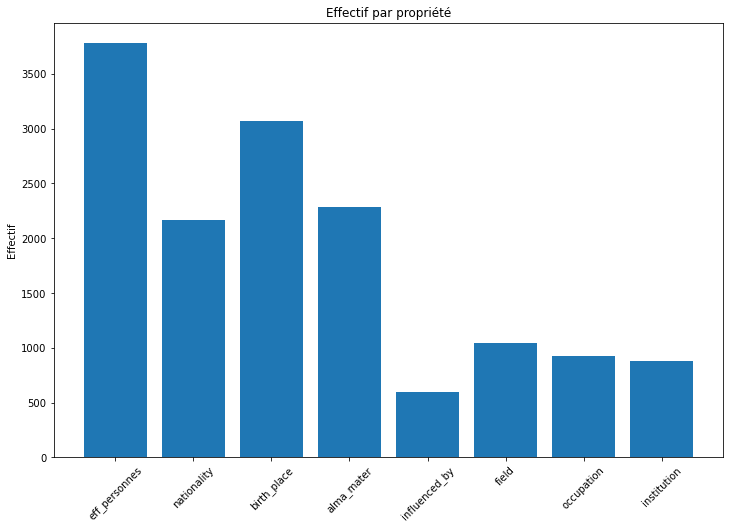

In [21]:
# Distribution des effectifs des propriétés renseignées

objects = [l for l in effectifs_proprietes.index]
eff = [l for l in effectifs_proprietes]

p1 = plt.bar(objects, eff)

#plt.xticks(l5Years)
plt.ylabel('Effectif')
plt.title('Effectif par propriété')
plt.gcf().set_size_inches(12, 8)
#plt.gca().axes.get_xaxis().set_visible(False)
# supported formats: eps, pdf, pgf, png, ps, raw, rgba, svg, svgz
#plt.savefig('exported_pictures/effectifs_naissances_par_annee.png', dpi=100, bbox_inches = "tight") #pdf, svg
plt.xticks(rotation=45)
plt.show()


## Création du graphe des propriétés

In [22]:
proprietes_personnes[:5]

[['Philipp_Emanuel_von_Fellenberg',
  ['birth_place', 'alma_mater', 'occupation'],
  3],
 ['Charles_Fourier', ['birth_place', 'influenced_by'], 2],
 ['David_Ricardo', ['nationality'], 1],
 ['Jacob_Aall', ['birth_place', 'nationality', 'occupation'], 3],
 ['James_Mill', ['birth_place', 'influenced_by'], 2]]

In [23]:
properties_edges = []
for pp in proprietes_personnes:
    local_properties = pp[1]
    len_prop = len(local_properties)
    # print(len_prop)
    if len_prop > 1:
        local_edges = []
        i = 0        
        while i < (len_prop-1):
            i_len = i + 1
            while i_len < (len_prop):
                local_edges.append((local_properties[i], local_properties[i_len]))
                i_len += 1        
            i += 1
        # print(local_edges)        
        properties_edges += local_edges

print(len(properties_edges))
properties_edges  [:5]

14270


[('birth_place', 'alma_mater'),
 ('birth_place', 'occupation'),
 ('alma_mater', 'occupation'),
 ('birth_place', 'influenced_by'),
 ('birth_place', 'nationality')]

In [24]:
graph_properties = nx.MultiGraph()
graph_properties.add_edges_from(properties_edges)
print(nx.info(graph_properties))

Name: 
Type: MultiGraph
Number of nodes: 7
Number of edges: 14270
Average degree: 4077.1429


In [25]:
effectif = dict([(i, {'effectif': v}) for i,v in effectifs_proprietes.items()])
effectif

{'eff_personnes': {'effectif': 3779},
 'nationality': {'effectif': 2169},
 'birth_place': {'effectif': 3070},
 'alma_mater': {'effectif': 2283},
 'influenced_by': {'effectif': 599},
 'field': {'effectif': 1042},
 'occupation': {'effectif': 928},
 'institution': {'effectif': 881}}

In [26]:
degree = dict([(d[0], {'degree': d[1]}) for d in nx.degree(graph_properties)])
print(degree)

{'birth_place': {'degree': 6250}, 'alma_mater': {'degree': 5917}, 'occupation': {'degree': 1801}, 'influenced_by': {'degree': 2103}, 'nationality': {'degree': 5829}, 'field': {'degree': 3538}, 'institution': {'degree': 3102}}


In [27]:
nx.set_node_attributes(graph_properties, effectif)
nx.set_node_attributes(graph_properties, degree)

In [28]:
graph_properties.nodes.data()

NodeDataView({'birth_place': {'effectif': 3070, 'degree': 6250}, 'alma_mater': {'effectif': 2283, 'degree': 5917}, 'occupation': {'effectif': 928, 'degree': 1801}, 'influenced_by': {'effectif': 599, 'degree': 2103}, 'nationality': {'effectif': 2169, 'degree': 5829}, 'field': {'effectif': 1042, 'degree': 3538}, 'institution': {'effectif': 881, 'degree': 3102}})

In [29]:
list(Counter([(u,v) for u,v in graph_properties.edges()]).items())

[(('birth_place', 'alma_mater'), 1870),
 (('birth_place', 'occupation'), 786),
 (('birth_place', 'influenced_by'), 491),
 (('birth_place', 'nationality'), 1722),
 (('birth_place', 'field'), 761),
 (('birth_place', 'institution'), 620),
 (('alma_mater', 'occupation'), 438),
 (('alma_mater', 'nationality'), 1519),
 (('alma_mater', 'field'), 862),
 (('alma_mater', 'influenced_by'), 426),
 (('alma_mater', 'institution'), 802),
 (('occupation', 'nationality'), 559),
 (('occupation', 'influenced_by'), 17),
 (('occupation', 'field'), 1),
 (('influenced_by', 'nationality'), 446),
 (('influenced_by', 'field'), 406),
 (('influenced_by', 'institution'), 317),
 (('nationality', 'field'), 864),
 (('nationality', 'institution'), 719),
 (('field', 'institution'), 644)]

In [30]:
lll = [(l[0][0], l[0][1], {'weight' : l[1]}) for l in list(Counter([(u,v) for u,v in graph_properties.edges()]).items())]
lll

[('birth_place', 'alma_mater', {'weight': 1870}),
 ('birth_place', 'occupation', {'weight': 786}),
 ('birth_place', 'influenced_by', {'weight': 491}),
 ('birth_place', 'nationality', {'weight': 1722}),
 ('birth_place', 'field', {'weight': 761}),
 ('birth_place', 'institution', {'weight': 620}),
 ('alma_mater', 'occupation', {'weight': 438}),
 ('alma_mater', 'nationality', {'weight': 1519}),
 ('alma_mater', 'field', {'weight': 862}),
 ('alma_mater', 'influenced_by', {'weight': 426}),
 ('alma_mater', 'institution', {'weight': 802}),
 ('occupation', 'nationality', {'weight': 559}),
 ('occupation', 'influenced_by', {'weight': 17}),
 ('occupation', 'field', {'weight': 1}),
 ('influenced_by', 'nationality', {'weight': 446}),
 ('influenced_by', 'field', {'weight': 406}),
 ('influenced_by', 'institution', {'weight': 317}),
 ('nationality', 'field', {'weight': 864}),
 ('nationality', 'institution', {'weight': 719}),
 ('field', 'institution', {'weight': 644})]

In [33]:
### Créer un graphe avec propriétés regroupées, avec indication de l'effectif
weig_graph_properties = nx.Graph()
weig_graph_properties.add_edges_from(lll)

In [34]:
print(nx.info(weig_graph_properties))

Name: 
Type: Graph
Number of nodes: 7
Number of edges: 20
Average degree:   5.7143


In [35]:
###  Ajout des effectifs des propriétés dans le graphe, paramètre 'weight'

## Documentation: 
# https://stackoverflow.com/questions/15590812/networkx-convert-multigraph-into-simple-graph-with-weighted-edges


wgp = nx.Graph()
for u,v,data in graph_properties.edges.data():
    w = data['weight'] if 'weight' in data else 1
    if wgp.has_edge(u,v):
        wgp[u][v]['weight'] += w
    else:
        wgp.add_edge(u, v, weight=w)

#### Inspection du graphe créé

In [44]:
nx.number_of_selfloops(weig_graph_properties), nx.is_weighted(weig_graph_properties)

(0, True)

In [45]:
[(u,v,data) for u,v,data in wgp.edges.data()][:3]

[('birth_place', 'alma_mater', {'weight': 1870}),
 ('birth_place', 'occupation', {'weight': 786}),
 ('birth_place', 'influenced_by', {'weight': 491})]

In [46]:
[(u,v,data) for u,v,data in weig_graph_properties.edges.data()][:3]

[('birth_place', 'alma_mater', {'weight': 1870}),
 ('birth_place', 'occupation', {'weight': 786}),
 ('birth_place', 'influenced_by', {'weight': 491})]

In [47]:
dict(graph_properties.nodes.data())

{'birth_place': {'effectif': 3070, 'degree': 6250},
 'alma_mater': {'effectif': 2283, 'degree': 5917},
 'occupation': {'effectif': 928, 'degree': 1801},
 'influenced_by': {'effectif': 599, 'degree': 2103},
 'nationality': {'effectif': 2169, 'degree': 5829},
 'field': {'effectif': 1042, 'degree': 3538},
 'institution': {'effectif': 881, 'degree': 3102}}

In [48]:
dict([(n, {'effectif': data['effectif']}) for n, data in graph_properties.nodes.data()])

{'birth_place': {'effectif': 3070},
 'alma_mater': {'effectif': 2283},
 'occupation': {'effectif': 928},
 'influenced_by': {'effectif': 599},
 'nationality': {'effectif': 2169},
 'field': {'effectif': 1042},
 'institution': {'effectif': 881}}

In [49]:
nx.set_node_attributes(weig_graph_properties, dict([(n, {'effectif': data['effectif']}) for n, data in graph_properties.nodes.data()]))
nx.set_node_attributes(weig_graph_properties, dict([(n, {'degree': data['degree']}) for n, data in graph_properties.nodes.data()]))

In [50]:
weig_graph_properties.nodes.data()

NodeDataView({'birth_place': {'effectif': 3070, 'degree': 6250}, 'alma_mater': {'effectif': 2283, 'degree': 5917}, 'occupation': {'effectif': 928, 'degree': 1801}, 'influenced_by': {'effectif': 599, 'degree': 2103}, 'nationality': {'effectif': 2169, 'degree': 5829}, 'field': {'effectif': 1042, 'degree': 3538}, 'institution': {'effectif': 881, 'degree': 3102}})

### Graphe qui permet d'inspecter les relations entre propriétés et leur fréquence

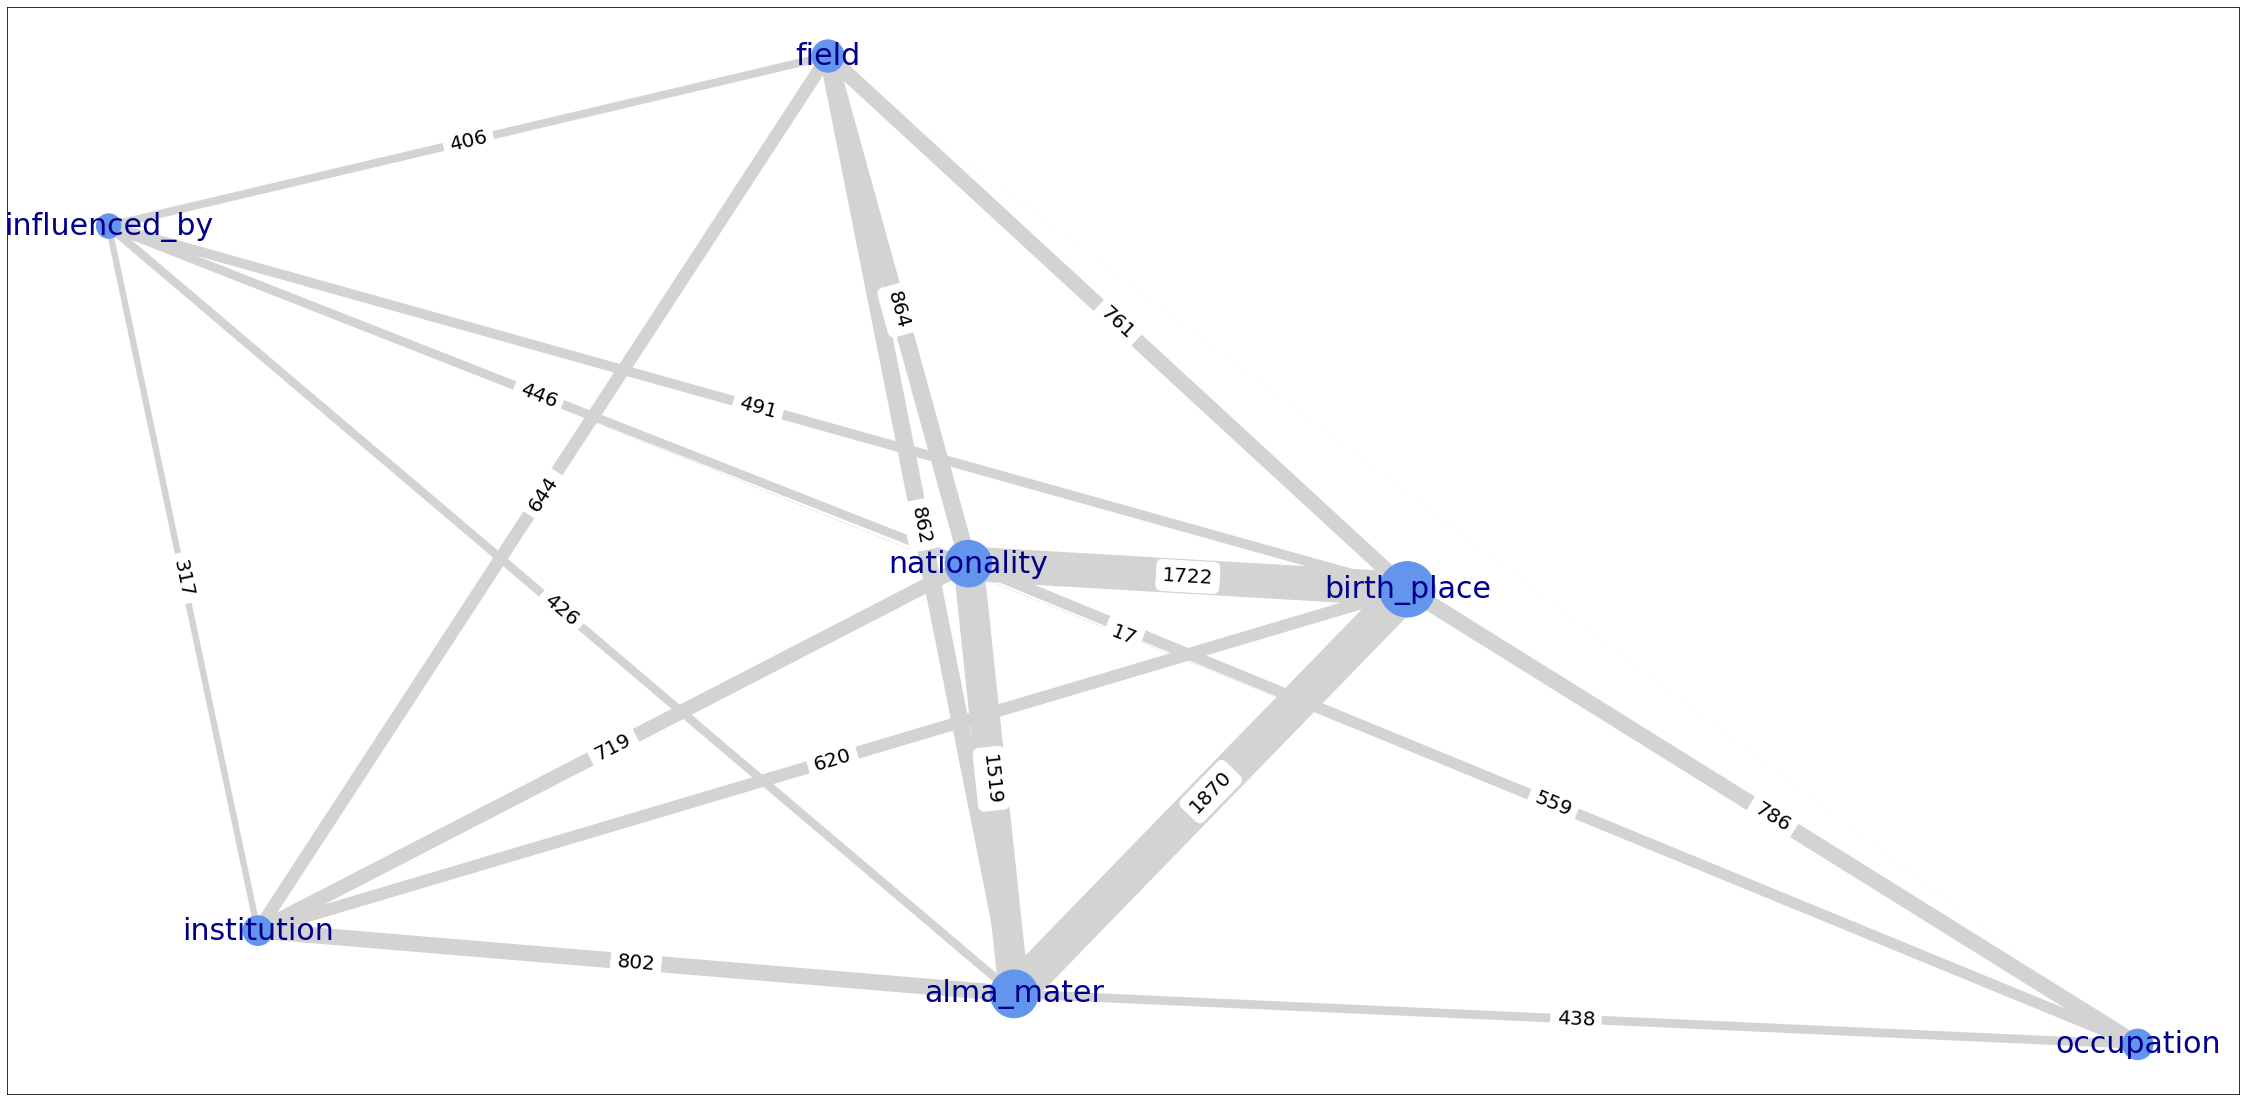

In [51]:
fig = plt.figure(figsize=(40,20))
pos = nx.spring_layout(weig_graph_properties, k = 1)
# pos = nx.kamada_kawai_layout(weig_graph_properties)
nx.draw_networkx(weig_graph_properties, pos, node_color = 'CornflowerBlue', font_color = 'DarkBlue',
                 font_size= 30,
                 node_size = [data['effectif'] for n,data in weig_graph_properties.nodes.data()],
                 edge_color='LightGray',
                 width = [ d['weight'] / 50 for u,v,d in weig_graph_properties.edges(data=True)])
nx.draw_networkx_edge_labels(weig_graph_properties, pos,
                 edge_labels = dict([((u,v,),str(int(d['weight'])) if d['weight'] > 1 else '') for u,v,d in weig_graph_properties.edges(data=True)]),
                 font_size = 20
                 )            
                 
plt.savefig("graphs/weig_graph_properties.pdf", format="pdf")
plt.show()

## Inspecter pour quelques variables les effectifs des autres caractéristiques

In [52]:
### Variables retenues pour l'exploration
variables_observees = {"alma_mater":"len_alma_mater", "nationality":"len_nationality", "field":"len_field", "occupation":"len_occupation", "institution":"len_institution", }
for i,v in variables_observees.items():
    print(i,v)

alma_mater len_alma_mater
nationality len_nationality
field len_field
occupation len_occupation
institution len_institution


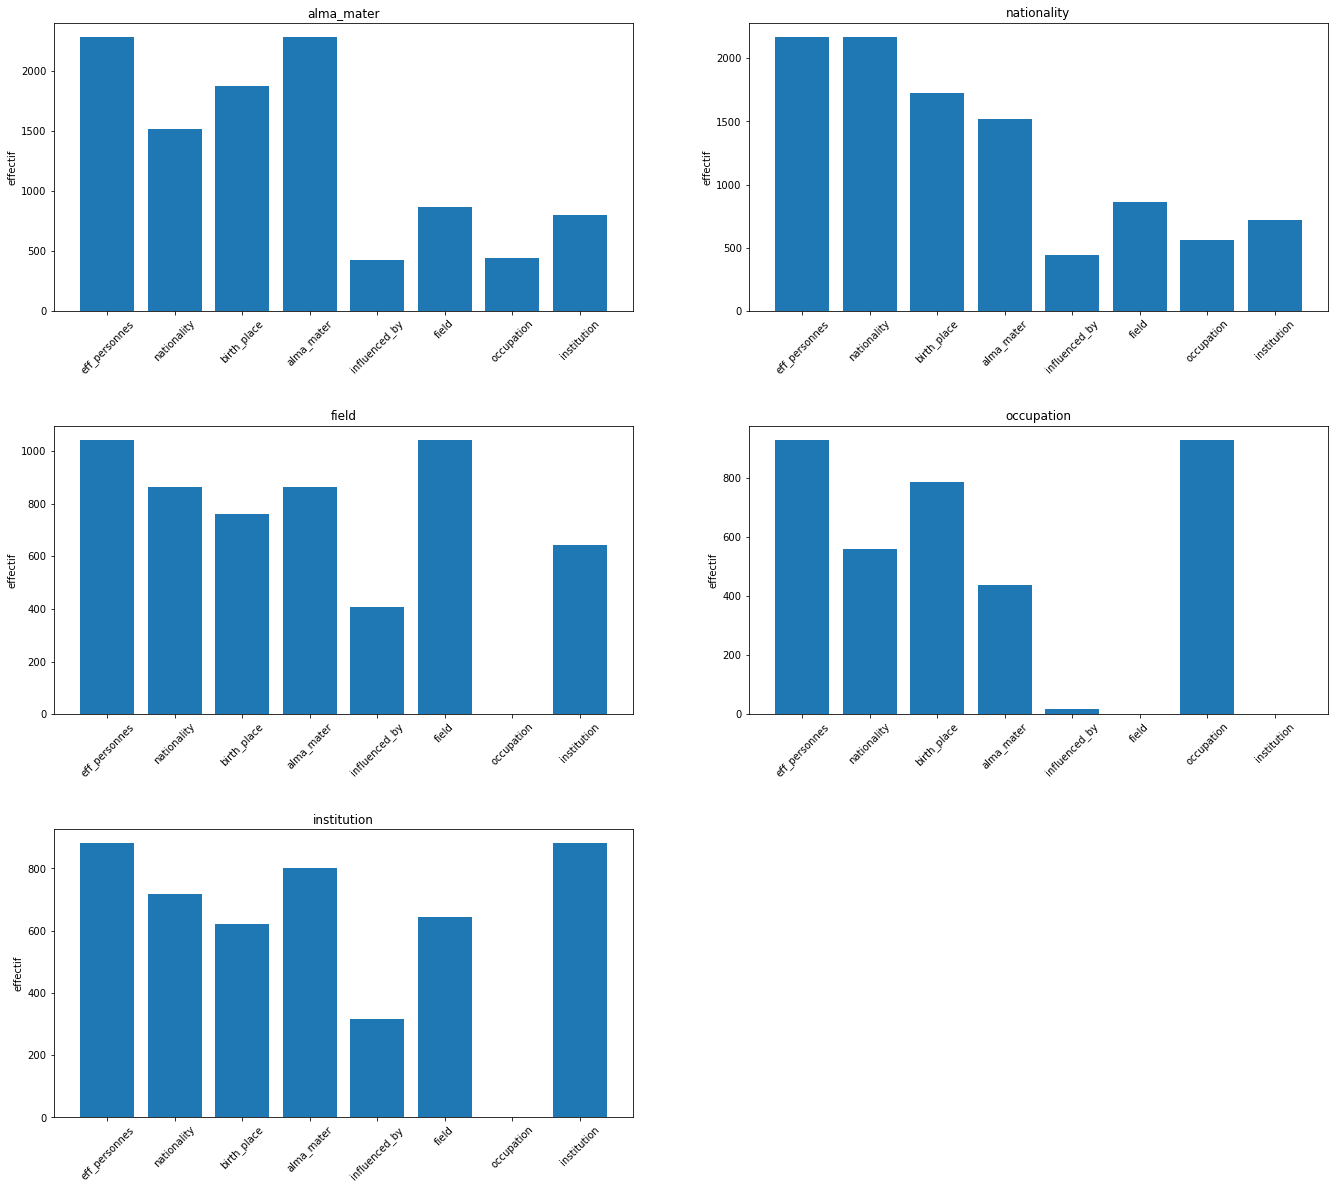

In [53]:
### Documenttaion:
# https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplot.html
# https://www.geeksforgeeks.org/how-to-set-the-spacing-between-subplots-in-matplotlib-in-python/

#fig = plt.figure()
#fig.supxlabel('Comparatif de ' + ', '.join([ix for ix,v in variables_observees.items()]), fontsize=20, va='top')   

plot_id = 1
plot_left = 1
for ix,v in variables_observees.items():
    
    #print(ix,v)

    eff_personnes = 0
    nationality = 0
    birth_place = 0
    alma_mater = 0
    influenced_by = 0
    field = 0
    occupation = 0
    institution = 0
    for i,r in list(personnes.iterrows()):
        # ce filtre, qui prend par ex. la forme " r['len_occupation'] > 0 ",
        # vérifie qu'une propriété (par ex. occupation) est renseignée et calcule ensuite 
        # quelles autres propriétés sont renseignées
        if r[v] > 0:
            eff_personnes += 1
            if r['len_nationality'] > 0:        
                nationality += 1
            if r['len_birth_place'] > 0:
                birth_place += 1
            if r['len_alma_mater'] > 0:
                alma_mater += 1
            if r['len_influenced_by'] > 0:
                influenced_by += 1
            if r['len_field'] > 0:
                field += 1
            if r['len_occupation'] > 0:
                occupation += 1
            if r['len_institution'] > 0:
                institution += 1
    effectifs_proprietes = pd.Series({"eff_personnes": eff_personnes, "nationality": nationality, "birth_place":birth_place, "alma_mater":alma_mater,\
                                  "influenced_by":influenced_by, "field":field, "occupation":occupation, "institution":institution })

    x = [l for l in effectifs_proprietes.index]
    y = [l for l in effectifs_proprietes]
    
 
    plt.subplot(3, 2, plot_id)

    plt.title(ix)
    
    plt.bar(x, y)
    plt.gcf().set_size_inches(12, 8)
    plt.xticks(rotation=45)

    plt.ylabel('effectif')

    
    plot_id += 1
    

plt.subplots_adjust(#left=0.1,
                   bottom=0.1, 
                   right=1.6, 
                   top=2, 
                   # wspace=0.4, 
                   hspace=0.4
                   )

plt.show()    

#### Commentaire

* Remarquer le caractère lacunaire de l'information pour bonne partie de la population.
* En particulier, soit on a le champs d'activité et les organisations ou entreprises d'appartenance, soit l'occupation(i.e. le métier)



# Filtrage

Le filtrage ci-dessus concernait une propriété à la foix. Ici on vérifie si des groupes de propriétés disponibles pour les personnes sont utilisables pour l'analye, par exemple 'field', 'institution' et nationality'

In [54]:
eff_personnes = 0
nationality = 0
birth_place = 0
alma_mater = 0
influenced_by = 0
field = 0
occupation = 0
institution = 0
for i,r in list(personnes.iterrows()):
    # if r['len_institution'] > 0:
    # if r['len_occupation'] > 0:
    if r['len_field'] > 0 and r['len_institution'] > 0 and r['len_nationality'] > 0:
    # if r['len_field'] > 0 and r['len_nationality'] > 0:
        eff_personnes += 1
        if r['len_nationality'] > 0:        
            nationality += 1
        if r['len_birth_place'] > 0:
            birth_place += 1
        if r['len_alma_mater'] > 0:
            alma_mater += 1
        if r['len_influenced_by'] > 0:
            influenced_by += 1
        if r['len_field'] > 0:
            field += 1
        if r['len_occupation'] > 0:
            occupation += 1
        if r['len_institution'] > 0:
            institution += 1
            
            
effectifs_proprietes_filtre = pd.Series({"eff_personnes": eff_personnes, "nationality": nationality, "birth_place":birth_place, "alma_mater":alma_mater,\
                                  "influenced_by":influenced_by, "field":field, "occupation":occupation, "institution":institution })
effectifs_proprietes_filtre            

eff_personnes    543
nationality      543
birth_place      382
alma_mater       506
influenced_by    223
field            543
occupation         0
institution      543
dtype: int64

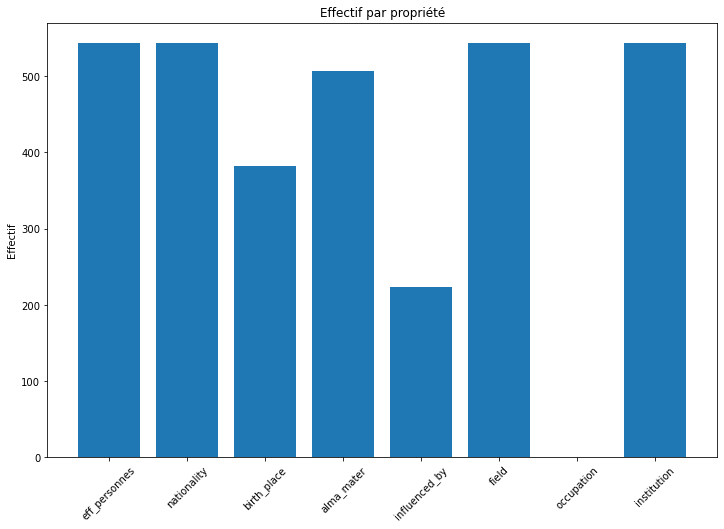

In [55]:
# Distribution par propriété

objects = [l for l in effectifs_proprietes_filtre.index]
eff = [l for l in effectifs_proprietes_filtre]

p1 = plt.bar(objects, eff)

#plt.xticks(l5Years)
plt.ylabel('Effectif')
plt.title('Effectif par propriété')
plt.gcf().set_size_inches(12, 8)
#plt.gca().axes.get_xaxis().set_visible(False)
# supported formats: eps, pdf, pgf, png, ps, raw, rgba, svg, svgz
#plt.savefig('exported_pictures/effectifs_naissances_par_annee.png', dpi=100, bbox_inches = "tight") #pdf, svg
plt.xticks(rotation=45)
plt.show()


### Filtrage sur les propriétés par personne

In [58]:
proprietes_personnes_filtered = []
for i,r in list(personnes.iterrows()):
    
    ### Filtre:
    
    if r['len_field'] > 0 and r['len_institution'] > 0 and r['len_nationality'] > 0: 
    
        properties = []    
        if r['len_birth_place'] > 0:
            properties.append('birth_place')
        if r['len_nationality'] > 0:        
            properties.append('nationality')
        if r['len_alma_mater'] > 0:
            properties.append('alma_mater')
        if r['len_influenced_by'] > 0:
            properties.append('influenced_by')
        if r['len_field'] > 0:
            properties.append('field')
        if r['len_occupation'] > 0:
            properties.append('occupation')
        if r['len_institution'] > 0:
            properties.append('institution')

        proprietes_personnes_filtered.append([i, properties, len(properties)])        

print(len(proprietes_personnes_filtered))    
proprietes_personnes_filtered[10:12]

543


[['Arthur_Cecil_Pigou',
  ['birth_place',
   'nationality',
   'alma_mater',
   'influenced_by',
   'field',
   'institution'],
  6],
 ['Farkas_Heller',
  ['birth_place', 'nationality', 'alma_mater', 'field', 'institution'],
  5]]

In [59]:
df_proprietes_personnes_filtered = pd.DataFrame(proprietes_personnes_filtered, columns=['uri_entity', 'proprietes', 'effectif'])
df_proprietes_personnes_filtered.head()

,uri_entity,proprietes,effectif
0,Franz_Hermann_Schulze-Delitzsch,"[birth_place, nationality, alma_mater, influen...",6
1,Lorenz_von_Stein,"[birth_place, nationality, alma_mater, influen...",6
2,Edward_Atkinson_(activist),"[birth_place, nationality, alma_mater, influen...",6
3,Arthur_Latham_Perry,"[birth_place, nationality, alma_mater, field, ...",5
4,Georg_Friedrich_Knapp,"[birth_place, nationality, influenced_by, fiel...",5


In [61]:
merged = pd.merge(df_proprietes_personnes_filtered,personnes, on='uri_entity', sort=False)
print(len(merged))
merged.sort_values(by=['annee']).loc[30:32,]

543


,uri_entity,proprietes,effectif,name,annee,nationality,len_nationality,birth_place,len_birth_place,alma_mater,len_alma_mater,influenced_by,len_influenced_by,field,len_field,occupation,len_occupation,institution,len_institution
30,Simon_Kuznets,"[birth_place, nationality, alma_mater, field, ...",5,Simon Kuznets,1901,United_States,1,"Pinsk,Russian_Empire",2,"Columbia_University,Kharkiv_National_Universit...",2,None,0,"Development_economics,Econometrics",2,None,0,"Columbia_University,Harvard_University,Johns_H...",5
31,Theodore_Schultz,"[birth_place, nationality, alma_mater, field, ...",5,Theodore Schultz,1902,American,1,"Arlington,_South_Dakota",2,"South_Dakota_State_University,University_of_Wi...",2,None,0,Agricultural_economics,1,None,0,"Iowa_State_University,University_of_Chicago",2
32,Tord_Palander,"[birth_place, nationality, alma_mater, field, ...",5,Tord Palander,1902,Sweden,1,"Stockholm,Sweden",2,Stockholm_University,1,None,0,"Regional_science,Urban_economics",2,None,0,"University_of_Gothenburg,University_of_Uppsala",2


In [62]:
min(merged['annee']),max(merged['annee'])

(1808, 1984)

In [63]:
y20_list = pd.RangeIndex(start=1801, stop=1990, step=20).to_list()
y20_list

[1801, 1821, 1841, 1861, 1881, 1901, 1921, 1941, 1961, 1981]

In [64]:
### coder les années les regroupant par périodes de vingt ans
merged['generation'] = pd.cut(merged['annee'], y20_list, right=False)
merged['generation'] = merged['generation'].apply(lambda row : str(int(row.left))+'-'+str(int(row.right)))
merged['generation'].head()

0    1801-1821
1    1801-1821
2    1821-1841
3    1821-1841
4    1841-1861
Name: generation, dtype: category
Categories (9, object): ['1801-1821' < '1821-1841' < '1841-1861' < '1861-1881' ... '1901-1921' < '1921-1941' < '1941-1961' < '1961-1981']

In [65]:
y10_list = pd.RangeIndex(start=1801, stop=1990, step=10).to_list()
y10_list[-5:]

[1941, 1951, 1961, 1971, 1981]

In [66]:
### coder les années les regroupant par périodes de vingt ans
merged['decades'] = pd.cut(merged['annee'], y10_list, right=False)
merged['decades'] = merged['decades'].apply(lambda row : str(int(row.left))+'-'+str(int(row.right)))
merged.head()

,uri_entity,proprietes,effectif,name,annee,nationality,len_nationality,birth_place,len_birth_place,alma_mater,...,influenced_by,len_influenced_by,field,len_field,occupation,len_occupation,institution,len_institution,generation,decades
0,Franz_Hermann_Schulze-Delitzsch,"[birth_place, nationality, alma_mater, influen...",6,Franz Hermann Schulze-Delitzsch,1808,German_nationality_law,1,"Delitzsch,Kingdom_of_Saxony",2,"Heidelberg_University,Leipzig_University",...,"Ferdinand_Lassalle,Friedrich_Wilhelm_Raiffeisen",2,"Microeconomics,Microfinance",2,None,0,"Prussian_National_Assembly,Reichstag_(German_E...",2,1801-1821,1801-1811
1,Lorenz_von_Stein,"[birth_place, nationality, alma_mater, influen...",6,Lorenz von Stein,1815,German_Empire,1,"Denmark,Duchy_of_Schleswig,Eckernförde",3,University_of_Kiel,...,"Benjamin_Constant,Charles_Fourier,G._W._F._Heg...",8,"Political_economics,Political_economy",2,None,0,University_of_Vienna,1,1801-1821,1811-1821
2,Edward_Atkinson_(activist),"[birth_place, nationality, alma_mater, influen...",6,Edward Atkinson (activist),1827,United_States_nationality_law,1,"Brookline,_Massachusetts,Massachusetts",3,"Dartmouth_College,University_of_South_Carolina",...,"Adam_Smith,Frédéric_Bastiat,John_Bright,Richar...",4,"Economics, politics",2,None,0,"American_Academy_of_Arts_and_Sciences,American...",2,1821-1841,1821-1831
3,Arthur_Latham_Perry,"[birth_place, nationality, alma_mater, field, ...",5,Arthur Latham Perry,1830,United States,1,"Lyme,_New_Hampshire",2,Williams_College,...,None,0,Macroeconomics,1,None,0,Williams_College,1,1821-1841,1821-1831
4,Georg_Friedrich_Knapp,"[birth_place, nationality, influenced_by, fiel...",5,Georg Friedrich Knapp,1842,"German,Germany",2,"Gießen,Grand_Duchy_of_Hesse",2,None,...,Ferdinand_Lassalle,1,"Monetary_economics,Statistics",2,None,0,University_of_Strasbourg,1,1841-1861,1841-1851


In [67]:
### Regrouper par génération
gb_generation = merged.groupby('generation').size()
gb_generation

generation
1801-1821      2
1821-1841      2
1841-1861      1
1861-1881     10
1881-1901     15
1901-1921     36
1921-1941    132
1941-1961    243
1961-1981    100
dtype: int64

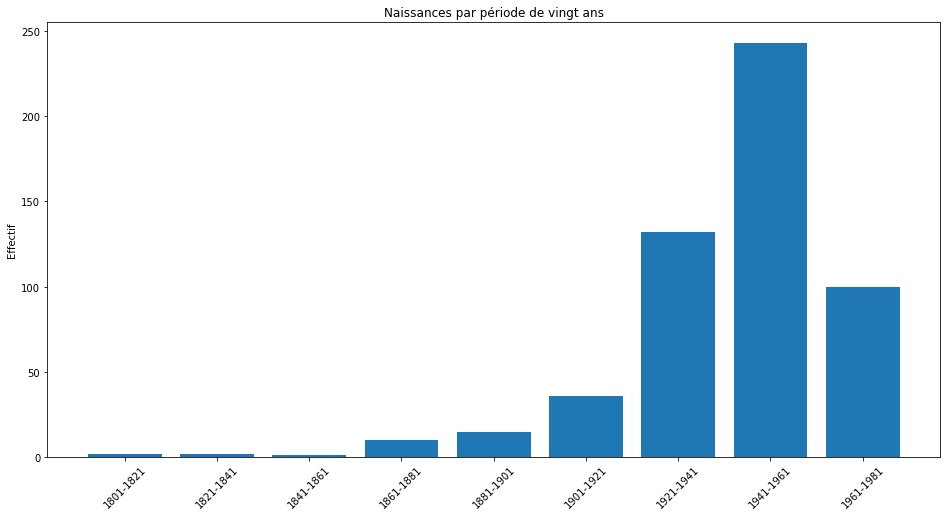

In [68]:
# Distribution par période de 10 ans de la population délimitée

objects = [l for l in gb_generation.index]
eff = [l for l in gb_generation]

p1 = plt.bar(objects, eff)

plt.ylabel('Effectif')
plt.title('Naissances par période de vingt ans')
plt.gcf().set_size_inches(16, 8)
# supported formats: eps, pdf, pgf, png, ps, raw, rgba, svg, svgz
# plt.savefig('exported_pictures/effectifs_annees_reference_par_periode.png', dpi=100, bbox_inches = "tight") #pdf, svg
plt.xticks(rotation=45)
plt.show()


In [71]:
### Fréquences par décades
gb_decades = merged.groupby('decades').size()
gb_decades

decades
1801-1811      1
1811-1821      1
1821-1831      2
1831-1841      0
1841-1851      1
1851-1861      0
1861-1871      3
1871-1881      7
1881-1891      7
1891-1901      8
1901-1911     12
1911-1921     24
1921-1931     58
1931-1941     74
1941-1951    117
1951-1961    126
1961-1971     72
1971-1981     28
dtype: int64

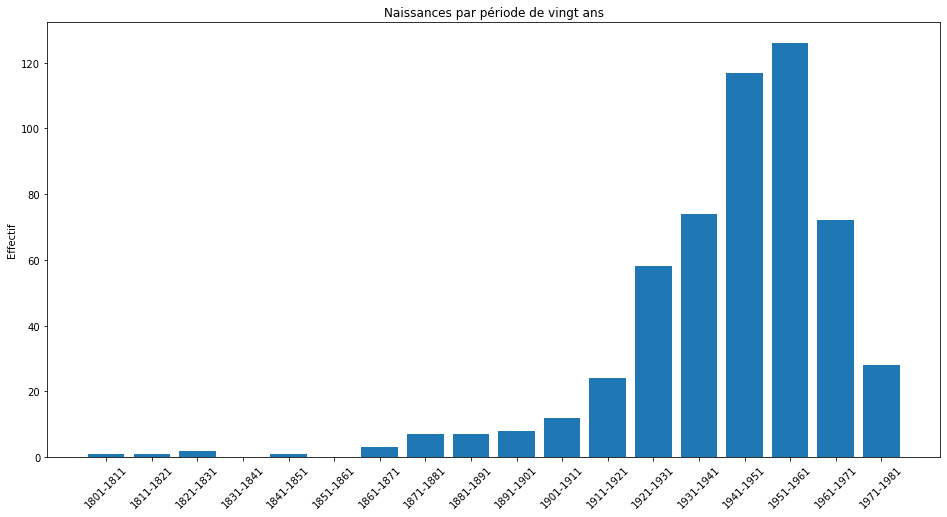

In [70]:
# Distribution par période de 10 ans de la population délimitée

objects = [l for l in gb_decades.index]
eff = [l for l in gb_decades]

p1 = plt.bar(objects, eff)

plt.ylabel('Effectif')
plt.title('Naissances par période de vingt ans')
plt.gcf().set_size_inches(16, 8)
# supported formats: eps, pdf, pgf, png, ps, raw, rgba, svg, svgz
# plt.savefig('exported_pictures/effectifs_annees_reference_par_periode.png', dpi=100, bbox_inches = "tight") #pdf, svg
plt.xticks(rotation=45)
plt.show()


# Considérations générales et analyses proposées


Ayant pris connaissances des principales propriétés de cette population, de leur liens mutuels (c'est-à-dire la co-fréquence des propriétés) ainsi que de leur caractère partiellement lacunaire il paraît opportun de proposer des analyses de données pour une seule variable, éventuellement mise en relation avec le temps.

On aura ainsi les carnets suivants:
* [Analyse des années et périodes de naissance](dbpedia_analyse_annees_naissance.ipynb)
* [Analyse des lieux de naissance](dbpedia_analyse_lieux.ipynb)
* [Analyse des nationalités](dbpedia_analyse_nationalites.ipynb)
* [Comparaison de variables qualitatives](dbpedia_comparaison_variables_qualitatives.ipynb)
* [Analyse de réseaux](dbpedia_analyse_reseaux.ipynb)



